First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [272]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
# !pip3 install -r requirements.txt

In [273]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

In [274]:
import uuid
import warnings
warnings.filterwarnings("ignore")
import re

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [275]:
executed_by ='stud-id_12412779'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [276]:
# group id for this project
group_id = '080'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12412779'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12449668'  # Replace the digits after "id_" with student B's student ID

In [277]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [278]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [279]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    'unit': 'http://qudt.org/vocab/unit/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [280]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [281]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Philipp" .',
f':{student_a} foaf:familyName "Moeßner" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12412779"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Vasili" .',
f':{student_b} foaf:familyName "Savin" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12449668"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

## Business Understanding 

In [282]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [283]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
We work for a private investor who wants to invest into apartments in Vienna to rent them on Airbnb.
The goal is to understand which types of apartments are likely to perform well and how different property characteristics influence quality, popularity and price.
We have access to the current listings of apartments in Vienna on Airbnb which serves as our data base for the analysis.
Data source: https://insideairbnb.com/get-the-data/
"""

business_objectives_comment = """
a) Identify which characteristics of Airbnb listings in Vienna are associated with higher rating scores.
b) Understand which property characteristics contribute to higher popularity, measured as monthly review frequency.
c) Identify which factors enable higher nightly prices, to support pricing and investment strategies.
d) Identify high-opportunity neighborhoods: detect districts with high demand but relatively low supply.
"""

business_success_criteria_comment = """
a) Provide a ranked list of factors (identify the top 3 modifiable attributes) that explain high rating scores.
b) Provide a ranked list of factors (identify the top 3 modifiable attributes) that contribute most to a high monthly review frequency.
c) Provide pricing guidelines based on modifiable attributes.
d) Provide a ranked list (identify the top 3) of high-opportunity districts.
"""

data_mining_goals_comment = """
a) Build a well-performing regression model for predicting rating score.
b) Build a regression model that predicts monthly review frequency based on listing characteristics and quantifies the influence of individual features.
c) Develop a regression model to predict the nightly price of listings based on property attributes, host characteristics, and location.
d) Identify / construct a reasonable measure indicating „demand“ of a district and compare it against the corresponding amount of listings.
"""

data_mining_success_criteria_comment = """
a) high R-squared (>0.4), low RMSE (<0.25) measure on the test set for the model
b) high R-squared (>0.5), low RMSE (<0.3) measure on the test set for the model
c) high R-squared (>0.6), low RMSE (<20€) measure on the test set for the model
Reason for increasingly harder metric thresholds: rating score is probably the most noisy / subjective category followed by rating frequency while price is probably the variable that is more closely tied to the „hard facts“ / features of a listing.
d) Classify all districts into one of the 3 categories: high, mid, low opportunity
"""

ai_risk_aspects_comment = """
Based on the current version of the EU AI Act, the proposed models would fall into the category of low-risk AI systems. 
The models do not operate in any regulated domains such as employment, access to essential services, migration or law enforcement and they do not involve biometric identification, social scoring of individuals etc. 
Therefore, no specific compliance requirements apply beyond general best practices regarding transparency, documentation, reproducibility and bias awareness.
"""


bu_ass_uuid_executor = "b651add0-c4ed-439b-8e36-5f62591f931e" # already generated by Philipp
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

In [284]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


#### Data loading and variable subsetting

In [285]:
data_load_code_writer = student_a

listings_path = 'listings.csv'
data_dict_path = 'var_dict.csv'

# ============================================================
# 1) DATA LOADING
# ============================================================

def load_and_subset_data(listings_path, data_dict_path):
    data_raw = pd.read_csv(listings_path)
    data_dict = pd.read_csv(data_dict_path)

    variable_subselection = [
        "id",
        "review_scores_rating",
        "review_scores_cleanliness",
        "review_scores_location",
        "review_scores_communication",
        "review_scores_value",
        "review_scores_accuracy",
        "review_scores_checkin",
        "host_is_superhost",
        "reviews_per_month",
        "number_of_reviews_l30d",
        "number_of_reviews_ly",
        "number_of_reviews",
        "accommodates",
        "room_type",
        "property_type",
        "minimum_nights",
        "instant_bookable",
        "has_availability",
        "availability_30",
        "price",
        "latitude",
        "longitude",
        "bathrooms",
        "beds",
        "bedrooms",
        "neighbourhood_cleansed",
        "calculated_host_listings_count",
        "host_total_listings_count",
        "estimated_occupancy_l365d",
        "estimated_revenue_l365d",
        "host_response_time",
        "host_response_rate",
        "host_acceptance_rate",
        "host_has_profile_pic",
        "host_identity_verified",
        "maximum_nights",
        "last_review"
    ]

    data = data_raw[variable_subselection].copy()
    data_dict_reduced = data_dict[data_dict['variable'].isin(variable_subselection)]

    numeric_units = ['count','day','night','count-per-month','percent','degree','EUR','rating-1-5']
    numeric_vars = data_dict_reduced[data_dict_reduced['unit'].isin(numeric_units)]
    non_numeric_vars = data_dict_reduced[~data_dict_reduced['unit'].isin(numeric_units)]

    return data_raw, data, data_dict, data_dict_reduced, numeric_vars, non_numeric_vars


start_time_ld = now()
data_raw, data, data_dict, data_dict_reduced, numeric_vars, non_numeric_vars = load_and_subset_data(
    listings_path,
    data_dict_path
)
end_time_ld = now()


# ============================================================
# 2) PROVENANCE: Performed activities
# ============================================================

dl_ass_uuid_executor = "12b98e02-b4f5-4faf-b8bd-573647b8b9e1"
dl_ass_uuid_writer   = "4b5313cb-c6df-409b-a5fe-0b3a2d57b5b2"

engine.insert([
    f':load_and_subset_data prov:qualifiedAssociation :{dl_ass_uuid_executor} .',
    f':{dl_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dl_ass_uuid_executor} rdf:type prov:Association .',
    f':{dl_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
], prefixes=prefixes)

ld_report = """
Load the raw Airbnb 'listings.csv' data for Vienna, join it with the variable
dictionary, select a subset of relevant variables, and split them into numeric
and non-numeric groups based on the data dictionary.
"""

engine.insert([
    ':load_and_subset_data rdf:type prov:Activity .',
    ':load_and_subset_data sc:isPartOf :data_understanding_phase .',
    ':load_and_subset_data rdfs:comment "Data Understanding – Data Loading and Variable Subsetting" .',
    f':load_and_subset_data rdfs:comment """{ld_report}""" .',
    f':load_and_subset_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_and_subset_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',

    f':load_and_subset_data prov:qualifiedAssociation :{dl_ass_uuid_writer} .',
    f':{dl_ass_uuid_writer} prov:agent :{data_load_code_writer} .',
    f':{dl_ass_uuid_writer} rdf:type prov:Association .',
    f':{dl_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':load_and_subset_data prov:used :airbnb_raw_listings .',
    ':load_and_subset_data prov:used :airbnb_raw_listings_path .',
    ':load_and_subset_data prov:used :airbnb_var_dict .',
    ':load_and_subset_data prov:used :airbnb_var_dict_path .',

    ':airbnb_raw_listings rdf:type prov:Entity .',
    ':airbnb_raw_listings_path rdf:type prov:Entity .',
    ':airbnb_raw_listings prov:wasDerivedFrom :airbnb_raw_listings_path .',

    ':airbnb_var_dict rdf:type prov:Entity .',
    ':airbnb_var_dict_path rdf:type prov:Entity .',
    ':airbnb_var_dict prov:wasDerivedFrom :airbnb_var_dict_path .',

    ':airbnb_data_subset rdf:type prov:Entity .',
    ':airbnb_data_subset prov:wasGeneratedBy :load_and_subset_data .',
    ':airbnb_data_subset prov:wasDerivedFrom :airbnb_raw_listings .',

    ':airbnb_data_dict_reduced rdf:type prov:Entity .',
    ':airbnb_data_dict_reduced prov:wasGeneratedBy :load_and_subset_data .',
    ':airbnb_data_dict_reduced prov:wasDerivedFrom :airbnb_var_dict .',

    ':airbnb_numeric_vars rdf:type prov:Entity .',
    ':airbnb_numeric_vars prov:wasGeneratedBy :load_and_subset_data .',
    ':airbnb_numeric_vars prov:wasDerivedFrom :airbnb_data_dict_reduced .',

    ':airbnb_non_numeric_vars rdf:type prov:Entity .',
    ':airbnb_non_numeric_vars prov:wasGeneratedBy :load_and_subset_data .',
    ':airbnb_non_numeric_vars prov:wasDerivedFrom :airbnb_data_dict_reduced .',
], prefixes=prefixes)


# ============================================================
# 3) Dataset descriptions
# ============================================================

engine.insert([
    ':airbnb_raw_listings rdf:type sc:Dataset .',
    ':airbnb_raw_listings sc:name "InsideAirbnb Vienna listings (raw)" .',
    ':airbnb_raw_listings sc:description "Raw Airbnb listings dataset for Vienna as downloaded from InsideAirbnb." .',

    ':airbnb_listings_csv rdf:type cr:FileObject .',
    ':airbnb_listings_csv sc:name "listings.csv" .',
    ':airbnb_listings_csv sc:encodingFormat "text/csv" .',
    ':airbnb_raw_listings sc:distribution :airbnb_listings_csv .',

    ':airbnb_var_dict rdf:type sc:Dataset .',
    ':airbnb_var_dict sc:name "Variable dictionary for Airbnb listings" .',
    ':airbnb_var_dict sc:description "Data dictionary describing variables, units and scales for the Airbnb listings dataset." .',

    ':airbnb_var_dict_csv rdf:type cr:FileObject .',
    ':airbnb_var_dict_csv sc:name "var_dict.csv" .',
    ':airbnb_var_dict_csv sc:encodingFormat "text/csv" .',
    ':airbnb_var_dict sc:distribution :airbnb_var_dict_csv .',
], prefixes=prefixes)


engine.insert([
    ':airbnb_data_subset rdf:type sc:Dataset .',
    ':airbnb_data_subset sc:name "Processed Airbnb listings subset (Vienna)" .',
    ':airbnb_data_subset sc:description "Subset of Airbnb listings restricted to variables relevant for rating, popularity, and pricing analysis." .',

    ':airbnb_recordset rdf:type cr:RecordSet .',
    ':airbnb_recordset sc:name "Processed Airbnb listings table (subset of variables)" .',
    ':airbnb_data_subset cr:recordSet :airbnb_recordset .',

    ':airbnb_data_dict_reduced rdf:type sc:Dataset .',
    ':airbnb_data_dict_reduced sc:name "Reduced variable dictionary for selected Airbnb variables" .',
    ':airbnb_data_dict_reduced sc:description "Data dictionary restricted to the variables selected for the analysis." .',
], prefixes=prefixes)


# ============================================================
# 4) Field definitions from data dictionary
# ============================================================

def unit_to_xsd(unit: str) -> str:
    if unit in ['count', 'day', 'night']:
        return 'xsd:integer'
    if unit in ['count-per-month', 'percent', 'degree', 'EUR', 'rating-1-5']:
        return 'xsd:double'
    if unit == 'boolean':
        return 'xsd:boolean'
    if unit == 'date':
        return 'xsd:dateTime'
    if unit in ['string', 'string-id', 'string-list', 'text', 'category']:
        return 'xsd:string'
    return 'xsd:string'


def unit_to_qudt(unit: str):
    if unit == 'count':
        return 'qudt:CountingUnit'
    if unit in ['day', 'night']:
        return 'unit:DAY'
    if unit == 'percent':
        return 'unit:PERCENT'
    if unit == 'degree':
        return 'unit:DEG'
    if unit == 'EUR':
        return 'unit:EUR'
    if unit == 'count-per-month':
        return 'unit:UNITLESS-PER-MONTH'
    if unit == 'rating-1-5':
        return 'unit:UNITLESS'
    return None


field_triples = []

for _, row in data_dict_reduced.iterrows():
    var = row['variable']
    raw_desc = str(row.get('description', '') or '')

    desc = (
        raw_desc
        .replace('\\', '\\\\')
        .replace('"', '\\"')
        .replace('\n', ' ')
        .replace('\r', ' ')
    )

    unit = row.get('unit', '')
    scale = str(row.get('scale_type', '') or '').lower()

    safe_var = re.sub(r'[^A-Za-z0-9_]', '_', var)
    field_iri = f':field_{safe_var}'

    xsd_type = unit_to_xsd(unit)
    qudt_unit = unit_to_qudt(unit)

    field_triples.append(f'{field_iri} rdf:type cr:Field .')
    field_triples.append(f'{field_iri} sc:name "{var}" .')
    field_triples.append(f'{field_iri} cr:dataType {xsd_type} .')
    if desc:
        field_triples.append(f'{field_iri} sc:description "{desc}" .')

    if qudt_unit:
        field_triples.append(f'{field_iri} qudt:unit {qudt_unit} .')

    if scale:
        scale_iri = f':Scale_{scale}'
        field_triples.append(f'{scale_iri} rdf:type :MeasurementScale .')
        field_triples.append(f'{scale_iri} rdfs:label "{scale} scale" .')
        field_triples.append(f'{field_iri} :hasScaleType {scale_iri} .')
        field_triples.append(f'{field_iri} :hasScaleTypeLiteral "{scale}" .')

    field_triples.append(f':airbnb_recordset cr:field {field_iri} .')

engine.insert(field_triples, prefixes=prefixes)


#### Calculate summary statistics

In [286]:
# ============================================================
# 1) Summary stats calculation
# ============================================================

summary_stats_code_writer = student_a

def calc_summary_stats():
    summary_stats = pd.DataFrame({'variable': [], 'mean': [], 'mode': [], 'median': [], 'var': [], 'min': [], 'max': [], 'skew': []})
    for var in numeric_vars['variable'].values:
        if var == 'price':
            data['price'] = (data['price'].str.replace(r'[\$,]', "", regex=True).str.replace(",", "", regex=False).astype(float))
        if var == 'host_acceptance_rate' or var == 'host_response_rate':
            data[var] = (data[var].str.replace(r'\%', "", regex=True).astype(float) / 100)
        else:
            data[var] = data[var].astype(float)
        current_measures = pd.DataFrame({'variable': [var],
                                        'unit': [data_dict_reduced[data_dict_reduced['variable'] == var]['unit'].values[0]],  
                                        'mean': [data[var].mean()], 
                                        'mode': [data[var].mode().values[0]], 
                                        'median': [data[var].median()], 
                                        'var': [data[var].var()], 
                                        'min': [data[var].min()], 
                                        'max': [data[var].max()], 
                                        'skew': [data[var].skew()]})
        summary_stats = pd.concat([summary_stats, current_measures], axis=0)

    for var in non_numeric_vars['variable'].values:
        if var == 'id':
            continue
        if var == 'last_review':
            data[var] = pd.to_datetime(data[var], format='%Y-%m-%d')
        current_measures = pd.DataFrame({'variable': [var], 
                                        'unit': [data_dict_reduced[data_dict_reduced['variable'] == var]['unit'].values[0]],  
                                        'mean': [np.nan], 
                                        'mode': [data[var].mode().values[0]], 
                                        'median': [np.nan], 
                                        'var': [np.nan], 
                                        'min': [np.nan], 
                                        'max': [np.nan], 
                                        'skew': [np.nan]})
        summary_stats = pd.concat([summary_stats, current_measures], axis=0)
    return summary_stats


start_time_ss = now()
summary_stats = calc_summary_stats()
end_time_ss = now()


# ============================================================
# 2) Interpretation
# ============================================================

def _escape_literal(s: str) -> str:
    return (
        str(s)
        .replace('\\', '\\\\')
        .replace('"', '\\"')
        .replace('\n', ' ')
        .replace('\r', ' ')
    )

ss_findings_comment = f"""
The summary statistics reveal highly skewed distributions for maximum nights to stay, bedrooms, price, revenue estimates and host listing counts.
Rating variables show low variance and left-skewness, which suggests a positivity bias in guest feedback.
These findings could motivate to use log-transformations and careful outlier treatment in the following data preparation steps.
"""

ss_findings_comment_escaped = _escape_literal(ss_findings_comment)


# ============================================================
# 3) Activity and Output Documentation
# ============================================================

ss_ass_uuid_executor = "d3f42815-832a-4a15-87cc-9d94294a8518"
ss_ass_uuid_writer   = "d9acbf2e-5fe5-4670-a087-35ae4bfdac30"

summary_stats_executor = [
    f':calc_summary_stats prov:qualifiedAssociation :{ss_ass_uuid_executor} .',
    f':{ss_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ss_ass_uuid_executor} rdf:type prov:Association .',
    f':{ss_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(summary_stats_executor, prefixes=prefixes)

ss_comment = """
Computation of summary statistics for the selected Airbnb Vienna variables (data understanding phase).
For numeric variables, mean, median, variance, min, max and skewness were computed.
For non-numeric variables, the mode was reported.
The resulting report is used to assess distributions, skewness, plausibility of values and potential preprocessing steps.
"""
ss_comment_escaped = _escape_literal(ss_comment)

summary_stats_activity = [
    ':calc_summary_stats rdf:type prov:Activity .',
    ':calc_summary_stats sc:isPartOf :data_understanding_phase .',
    ':calc_summary_stats rdfs:comment "Data Understanding – Summary Statistics" .',
    f':calc_summary_stats rdfs:comment "{ss_comment_escaped}" .',
    f':calc_summary_stats prov:startedAtTime "{start_time_ss}"^^xsd:dateTime .',
    f':calc_summary_stats prov:endedAtTime "{end_time_ss}"^^xsd:dateTime .',

    f':calc_summary_stats prov:qualifiedAssociation :{ss_ass_uuid_writer} .',
    f':{ss_ass_uuid_writer} prov:agent :{summary_stats_code_writer} .',
    f':{ss_ass_uuid_writer} rdf:type prov:Association .',
    f':{ss_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':calc_summary_stats prov:used :data .',
    ':calc_summary_stats prov:used :data_dict_reduced .',

    ':summary_statistics rdf:type prov:Entity .',
    ':summary_statistics rdf:type sc:Dataset .',
    ':summary_statistics sc:name "Summary statistics report (Airbnb Vienna subset)" .',
    ':summary_statistics sc:description "Descriptive statistics for selected variables; numeric: mean/median/var/min/max/skew, non-numeric: mode." .',
    ':summary_statistics prov:wasGeneratedBy :calc_summary_stats .',
    ':summary_statistics prov:wasDerivedFrom :data .',

    f':summary_statistics rdfs:comment "{ss_findings_comment_escaped}" .',
]
engine.insert(summary_stats_activity, prefixes=prefixes)


# ============================================================
# 4) Croissant structure for the summary statistics table
# ============================================================

summary_stats_structure = [
    ':summary_statistics cr:recordSet :summary_recordset .',
    ':summary_recordset rdf:type cr:RecordSet .',
    ':summary_recordset sc:name "Summary statistics table" .',
    ':summary_recordset sc:description "Tabular report containing descriptive statistics per variable." .',

    ':summary_recordset cr:field :ss_field_variable .',
    ':ss_field_variable rdf:type cr:Field .',
    ':ss_field_variable sc:name "variable" .',
    ':ss_field_variable sc:description "Name of the variable the statistics refer to." .',
    ':ss_field_variable cr:dataType xsd:string .',

    ':summary_recordset cr:field :ss_field_unit .',
    ':ss_field_unit rdf:type cr:Field .',
    ':ss_field_unit sc:name "unit" .',
    ':ss_field_unit sc:description "Unit label of the variable (as defined in the project data dictionary)." .',
    ':ss_field_unit cr:dataType xsd:string .',

    ':summary_recordset cr:field :ss_field_mean .',
    ':ss_field_mean rdf:type cr:Field .',
    ':ss_field_mean sc:name "mean" .',
    ':ss_field_mean sc:description "Arithmetic mean (numeric variables only; otherwise NaN)." .',
    ':ss_field_mean cr:dataType xsd:double .',

    ':summary_recordset cr:field :ss_field_mode .',
    ':ss_field_mode rdf:type cr:Field .',
    ':ss_field_mode sc:name "mode" .',
    ':ss_field_mode sc:description "Most frequent value (mode). For numeric variables computed numerically; for categorical variables the most frequent category." .',
    ':ss_field_mode cr:dataType xsd:string .',

    ':summary_recordset cr:field :ss_field_median .',
    ':ss_field_median rdf:type cr:Field .',
    ':ss_field_median sc:name "median" .',
    ':ss_field_median sc:description "Median (numeric variables only; otherwise NaN)." .',
    ':ss_field_median cr:dataType xsd:double .',

    ':summary_recordset cr:field :ss_field_var .',
    ':ss_field_var rdf:type cr:Field .',
    ':ss_field_var sc:name "var" .',
    ':ss_field_var sc:description "Sample variance (numeric variables only; otherwise NaN)." .',
    ':ss_field_var cr:dataType xsd:double .',

    ':summary_recordset cr:field :ss_field_min .',
    ':ss_field_min rdf:type cr:Field .',
    ':ss_field_min sc:name "min" .',
    ':ss_field_min sc:description "Minimum observed value (numeric variables only; otherwise NaN)." .',
    ':ss_field_min cr:dataType xsd:double .',

    ':summary_recordset cr:field :ss_field_max .',
    ':ss_field_max rdf:type cr:Field .',
    ':ss_field_max sc:name "max" .',
    ':ss_field_max sc:description "Maximum observed value (numeric variables only; otherwise NaN)." .',
    ':ss_field_max cr:dataType xsd:double .',

    ':summary_recordset cr:field :ss_field_skew .',
    ':ss_field_skew rdf:type cr:Field .',
    ':ss_field_skew sc:name "skew" .',
    ':ss_field_skew sc:description "Skewness of the distribution (numeric variables only; otherwise NaN)." .',
    ':ss_field_skew cr:dataType xsd:double .',
]
engine.insert(summary_stats_structure, prefixes=prefixes)

In [287]:
summary_stats

,variable,mean,mode,median,var,min,max,skew,unit
0,host_response_rate,0.935600,1.0,1.000000,3.045820e-02,0.000000,1.000000e+00,-4.010845,percent
0,host_acceptance_rate,0.893048,1.0,0.990000,5.120233e-02,0.000000,1.000000e+00,-2.726001,percent
0,host_total_listings_count,45.205737,1.0,5.000000,2.234147e+04,1.000000,8.769000e+03,19.664260,count
0,latitude,48.203993,48.164178,48.203255,5.062487e-04,48.126310,4.829663e+01,0.205603,degree
0,longitude,16.360794,16.315545,16.359630,1.254780e-03,16.198216,1.654339e+01,0.279874,degree
0,accommodates,3.476598,2.0,3.000000,3.692467e+00,1.000000,1.600000e+01,1.939175,count
0,bathrooms,1.185304,1.0,1.000000,2.368154e-01,0.000000,1.200000e+01,5.913963,count
0,bedrooms,1.341932,1.0,1.000000,9.251027e-01,0.000000,5.000000e+01,12.656571,count
0,beds,2.030838,1.0,2.000000,1.852409e+00,0.000000,2.000000e+01,2.871872,count
0,price,156.727634,72.0,93.000000,2.845836e+05,13.000000,1.000000e+04,14.168383,EUR


#### Calculate variable correlations

In [288]:
var_corr_code_writer = student_a

def numerical_data_subset():
    # exclude categorical variables
    exclude_units = ['category', 'string', 'string-id', 'string-list', 'date']
    vars_for_corr = data_dict_reduced[~data_dict_reduced['unit'].isin(exclude_units)]['variable'].values
    data_numerical = data[vars_for_corr].copy()

    # transform every boolean variable to boolean values
    data_numerical[data_dict_reduced[data_dict_reduced['unit'] == 'boolean']['variable'].values] = data_numerical[data_dict_reduced[data_dict_reduced['unit'] == 'boolean']['variable'].values].apply(lambda x: x.apply(lambda y: True if y == 't' else False if y == 'f' else y))

    # transform every other variable to float
    data_numerical = data_numerical.astype(float)

    return data_numerical

# ============================================================
# 1) Compute correlations
# ============================================================

start_time_cr = now()
data_numerical = numerical_data_subset()
var_correlations = data_numerical.corr(method='pearson')
end_time_cr = now()


# ============================================================
# 2) Activity and Output Documentation
# ============================================================

cr_ass_uuid_executor = "2ffdde5e-4386-4b5d-b525-5e0627531c70"
cr_ass_uuid_writer   = "121fb775-18eb-4973-8f7e-b3449bcb36ee"

corr_executor = [
    f':compute_correlations prov:qualifiedAssociation :{cr_ass_uuid_executor} .',
    f':{cr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{cr_ass_uuid_executor} rdf:type prov:Association .',
    f':{cr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(corr_executor, prefixes=prefixes)

cr_comment = """
Compute Pearson correlation coefficients on a numerical subset of the Airbnb Vienna dataset.
Non-numeric attributes (strings, categories, dates) are excluded based on the data dictionary units.
Boolean variables are mapped from 't'/'f' to 1/0 and all values are coerced to numeric.
The correlation matrix is used for exploratory analysis.
"""
cr_comment_escaped = _escape_literal(cr_comment)

corr_activity = [
    ':compute_correlations rdf:type prov:Activity .',
    ':compute_correlations sc:isPartOf :data_understanding_phase .',
    ':compute_correlations rdfs:comment "Data Understanding – Correlation Analysis" .',
    f':compute_correlations rdfs:comment "{cr_comment_escaped}" .',
    f':compute_correlations prov:startedAtTime "{start_time_cr}"^^xsd:dateTime .',
    f':compute_correlations prov:endedAtTime "{end_time_cr}"^^xsd:dateTime .',

    f':compute_correlations prov:qualifiedAssociation :{cr_ass_uuid_writer} .',
    f':{cr_ass_uuid_writer} prov:agent :{var_corr_code_writer} .',
    f':{cr_ass_uuid_writer} rdf:type prov:Association .',
    f':{cr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':compute_correlations prov:used :data .',
    ':compute_correlations prov:used :data_dict_reduced .',

    ':data_numerical rdf:type prov:Entity .',
    ':data_numerical rdf:type sc:Dataset .',
    ':data_numerical sc:name "Numerical subset for correlation analysis" .',
    ':data_numerical sc:description "Subset excluding non-numeric units; booleans mapped to 0/1; coerced to numeric." .',
    ':data_numerical prov:wasGeneratedBy :compute_correlations .',
    ':data_numerical prov:wasDerivedFrom :data .',

    ':correlation_matrix rdf:type prov:Entity .',
    ':correlation_matrix rdf:type sc:Dataset .',
    ':correlation_matrix sc:name "Pearson correlation matrix (numerical subset)" .',
    ':correlation_matrix sc:description "Pairwise Pearson correlations computed on the numerical subset of the dataset." .',
    ':correlation_matrix prov:wasGeneratedBy :compute_correlations .',
    ':correlation_matrix prov:wasDerivedFrom :data_numerical .',
]
engine.insert(corr_activity, prefixes=prefixes)

corr_table_triples = [
    ':correlation_recordset rdf:type cr:RecordSet .',
    ':correlation_recordset sc:name "Correlation matrix table" .',
    ':correlation_recordset sc:description "Square matrix where rows and columns correspond to numerical variables and each cell contains a Pearson correlation coefficient." .',
    ':correlation_matrix cr:recordSet :correlation_recordset .',

    ':corr_field_row rdf:type cr:Field .',
    ':corr_field_row sc:name "row_variable" .',
    ':corr_field_row sc:description "Name of the variable corresponding to the row of the correlation matrix." .',
    ':corr_field_row cr:dataType xsd:string .',

    ':corr_field_col rdf:type cr:Field .',
    ':corr_field_col sc:name "column_variable" .',
    ':corr_field_col sc:description "Name of the variable corresponding to the column of the correlation matrix." .',
    ':corr_field_col cr:dataType xsd:string .',

    ':corr_field_value rdf:type cr:Field .',
    ':corr_field_value sc:name "pearson_correlation" .',
    ':corr_field_value sc:description "Pearson correlation coefficient between the row and column variable (range [-1, 1])." .',
    ':corr_field_value cr:dataType xsd:double .',

    ':correlation_recordset cr:field :corr_field_row .',
    ':correlation_recordset cr:field :corr_field_col .',
    ':correlation_recordset cr:field :corr_field_value .',
]
engine.insert(corr_table_triples, prefixes=prefixes)


# ============================================================
# 3) Interpretation activity
# ============================================================

start_time_ci = now()
end_time_ci = now()

ci_ass_uuid_executor = "26b9f497-9dc3-41da-a4fc-7805ed14e697"

interpretation_text = """
Interpretation of correlation analysis:
- reviews_per_month shows strong positive correlations with other variables related to review-count (number_of_reviews_l30d, number_of_reviews_ly, number_of_reviews),
  which is expected because they capture related constructs. For feature selection, these variables should be treated carefully to avoid target leakage.
  Additional positive correlations with host and booking convenience indicators (instant_bookable, host_is_superhost, host_response_rate, host_identity_verified)
  suggest that professional host behavior and reduced booking friction may be associated with higher review frequency.
- price correlates weak-to-moderately with size/capacity related variables (bedrooms, beds, accommodates, bathrooms), which is expected. The association with
  host_total_listings_count may indicate systematic pricing differences between professional and private hosts.
- review_scores_rating is strongly correlated with the sub-scores (value, accuracy, cleanliness, communication, checkin, location), which is expected because
  the overall rating is derived from these aspects. Using all sub-scores as predictors for the overall score could reduce business insight and
  introduce multicollinearity; alternatively one could model overall rating from all other attributes.
"""
interpretation_text_escaped = _escape_literal(interpretation_text)

corr_interpret_activity = [
    ':interpret_correlations rdf:type prov:Activity .',
    ':interpret_correlations sc:isPartOf :data_understanding_phase .',
    ':interpret_correlations rdfs:comment "Data Understanding – Interpretation of Correlations" .',
    f':interpret_correlations rdfs:comment "{interpretation_text_escaped}" .',
    f':interpret_correlations prov:startedAtTime "{start_time_ci}"^^xsd:dateTime .',
    f':interpret_correlations prov:endedAtTime "{end_time_ci}"^^xsd:dateTime .',

    f':interpret_correlations prov:qualifiedAssociation :{ci_ass_uuid_executor} .',
    f':{ci_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ci_ass_uuid_executor} rdf:type prov:Association .',
    f':{ci_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    ':interpret_correlations prov:used :correlation_matrix .',

    ':correlation_insights rdf:type prov:Entity .',
    ':correlation_insights prov:wasGeneratedBy :interpret_correlations .',
    f':correlation_insights rdfs:comment "{interpretation_text_escaped}" .',
]
engine.insert(corr_interpret_activity, prefixes=prefixes)

In [289]:
print('Correlations of \'amount of reviews per month\':')
var_correlations['reviews_per_month'].sort_values(ascending=False)

Correlations of 'amount of reviews per month':


reviews_per_month                 1.000000
number_of_reviews_l30d            0.786855
estimated_occupancy_l365d         0.638874
number_of_reviews_ly              0.632685
number_of_reviews                 0.518389
host_acceptance_rate              0.223987
instant_bookable                  0.216333
estimated_revenue_l365d           0.208234
host_is_superhost                 0.199389
host_response_rate                0.164836
host_identity_verified            0.139307
accommodates                      0.102132
availability_30                   0.078796
review_scores_value               0.056116
review_scores_communication       0.049139
review_scores_checkin             0.045075
review_scores_cleanliness         0.044774
longitude                         0.028076
host_total_listings_count         0.025975
review_scores_accuracy            0.024573
beds                              0.022479
review_scores_rating              0.019185
calculated_host_listings_count    0.015255
host_has_pr

In [290]:
print('Correlations of \'price\':')
var_correlations['price'].sort_values(ascending=False)

Correlations of 'price':


price                             1.000000
host_total_listings_count         0.320060
estimated_revenue_l365d           0.222448
maximum_nights                    0.123266
bedrooms                          0.098303
accommodates                      0.080376
beds                              0.078213
instant_bookable                  0.065834
latitude                          0.048085
bathrooms                         0.047483
review_scores_location            0.040844
review_scores_cleanliness         0.027828
host_response_rate                0.015357
host_has_profile_pic              0.014435
longitude                         0.010881
review_scores_rating              0.007471
review_scores_accuracy            0.006216
availability_30                   0.004743
host_identity_verified            0.004310
calculated_host_listings_count   -0.002211
review_scores_value              -0.003207
review_scores_checkin            -0.007240
host_acceptance_rate             -0.009034
review_scor

In [291]:
print('Correlations of \'overall rating score\':')
var_correlations['review_scores_rating'].sort_values(ascending=False)

Correlations of 'overall rating score':


review_scores_rating              1.000000
review_scores_value               0.836846
review_scores_accuracy            0.821541
review_scores_cleanliness         0.788532
review_scores_communication       0.714405
review_scores_checkin             0.671644
review_scores_location            0.629173
host_is_superhost                 0.238975
estimated_occupancy_l365d         0.121828
number_of_reviews                 0.111436
number_of_reviews_ly              0.104162
estimated_revenue_l365d           0.095679
host_response_rate                0.043618
bathrooms                         0.040571
minimum_nights                    0.033021
host_has_profile_pic              0.027473
latitude                          0.024539
host_identity_verified            0.023464
reviews_per_month                 0.019185
number_of_reviews_l30d            0.010312
price                             0.007471
longitude                         0.000370
bedrooms                         -0.001852
maximum_nig

#### Inspect the amount of missing values per variable

In [292]:
missing_vals_code_writer = student_a

def missing_values_summary():
    missing_values = pd.DataFrame({'variable': [], 'abs_number': [], 'rel_fraction': []})
    for var in data_dict_reduced['variable'].values:
        if var == 'id':
            continue
        df = pd.DataFrame({'variable': [var], 'abs_number': [data[var].isna().sum()], 'rel_fraction': [data[var].isna().mean()]})
        missing_values = pd.concat([missing_values, df], axis=0)
    missing_values = missing_values.sort_values('rel_fraction', ascending=False)
    return missing_values

# ============================================================
# 1) Compute missing values
# ============================================================

start_time_ld = now()

missing_values = missing_values_summary()
missing_dummies = data.apply(lambda col: col.isna().astype(int), axis=0)
missing_dummies.columns = [f"{c}_missing" for c in data.columns]
corr_matrix = pd.concat([missing_dummies, data_numerical], axis=1).corr()

end_time_ld = now()

# missing prices are strongly correlated to a lot of other variables that also have high missing value counts 
# -> deleting the instances with missing price values would also solve the missing value issue in a lot of other variables
# -> there is no reasonable strategy of filling values for 27% of the data instances
# -> removing the data instances would not shrink the dataset below 10000 data instances -> should be enough data to train the models
# -> RECOMMENDATION: remove data instances where 'price' values are missing

# ============================================================
# 2) Activity and Output Documentation
# ============================================================
mv_ass_uuid_executor = "8a3d2f6e-4c4f-4c3e-b9f6-8c72f4c5e321"
mv_ass_uuid_writer   = "5d6b1e9f-3c3a-44e4-9b8a-2e2a6a9a7c11"

mv_comment = """
Analyze missing values for all selected variables by computing absolute and relative missing counts.
Additionally, missingness indicator variables are created and correlated with numerical attributes
to assess whether missing values occur randomly or follow a structural pattern.
"""
mv_comment_escaped = _escape_literal(mv_comment)

missing_values_activity = [
    ':analyze_missing_values rdf:type prov:Activity .',
    ':analyze_missing_values sc:isPartOf :data_understanding_phase .',
    ':analyze_missing_values rdfs:comment "Data Understanding – Missing Value Analysis" .',
    f':analyze_missing_values rdfs:comment "{mv_comment_escaped}" .',
    f':analyze_missing_values prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':analyze_missing_values prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',

    f':analyze_missing_values prov:qualifiedAssociation :{mv_ass_uuid_writer} .',
    f':{mv_ass_uuid_writer} prov:agent :{missing_vals_code_writer} .',
    f':{mv_ass_uuid_writer} rdf:type prov:Association .',
    f':{mv_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    f':analyze_missing_values prov:qualifiedAssociation :{mv_ass_uuid_executor} .',
    f':{mv_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{mv_ass_uuid_executor} rdf:type prov:Association .',
    f':{mv_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    ':analyze_missing_values prov:used :data .',
    ':analyze_missing_values prov:used :data_dict_reduced .',

    ':missing_values_summary rdf:type prov:Entity .',
    ':missing_values_summary rdf:type sc:Dataset .',
    ':missing_values_summary sc:name "Missing values summary table" .',
    ':missing_values_summary sc:description "Table containing absolute and relative missing value counts per variable." .',
    ':missing_values_summary prov:wasGeneratedBy :analyze_missing_values .',
    ':missing_values_summary prov:wasDerivedFrom :data .',

    ':missingness_correlation rdf:type prov:Entity .',
    ':missingness_correlation rdf:type sc:Dataset .',
    ':missingness_correlation sc:name "Missingness correlation matrix" .',
    ':missingness_correlation sc:description "Correlation matrix between missingness indicators and numerical variables to assess structural missingness." .',
    ':missingness_correlation prov:wasGeneratedBy :analyze_missing_values .',
    ':missingness_correlation prov:wasDerivedFrom :data .',
]
engine.insert(missing_values_activity, prefixes=prefixes)

missing_values_structure = [
    ':missing_values_summary cr:recordSet :missing_values_recordset .',
    ':missing_values_recordset rdf:type cr:RecordSet .',
    ':missing_values_recordset sc:name "Missing values summary table" .',
    ':missing_values_recordset sc:description "Table with missing value counts per variable (absolute and relative)." .',

    ':missing_values_recordset cr:field :mv_field_variable .',
    ':mv_field_variable rdf:type cr:Field .',
    ':mv_field_variable sc:name "variable" .',
    ':mv_field_variable sc:description "Variable name." .',
    ':mv_field_variable cr:dataType xsd:string .',

    ':missing_values_recordset cr:field :mv_field_abs .',
    ':mv_field_abs rdf:type cr:Field .',
    ':mv_field_abs sc:name "abs_number" .',
    ':mv_field_abs sc:description "Absolute number of missing values for the variable." .',
    ':mv_field_abs cr:dataType xsd:integer .',

    ':missing_values_recordset cr:field :mv_field_rel .',
    ':mv_field_rel rdf:type cr:Field .',
    ':mv_field_rel sc:name "rel_fraction" .',
    ':mv_field_rel sc:description "Fraction of missing values for the variable (missing_count / number_of_rows)." .',
    ':mv_field_rel cr:dataType xsd:double .',

    ':missing_values_recordset cr:field :mv_field_method .',
    ':mv_field_method rdf:type cr:Field .',
    ':mv_field_method sc:name "method" .',
    ':mv_field_method sc:description "Method used to compute missing values (pandas isna-based count and mean)." .',
    ':mv_field_method cr:dataType xsd:string .',
]
engine.insert(missing_values_structure, prefixes=prefixes)

# ============================================================
# 3) Interpretation activity
# ============================================================

start_time_mvi = now()
end_time_mvi = now()

mvi_ass_uuid_executor = "0d1e5bfa-91c4-4b6a-9c1d-61f44c29c992"

missing_interpretation = """
The missing value analysis reveals a high proportion of missing values for several variables
(e.g. price, estimated_revenue_l365d, beds, bathrooms, host_response_rate), affecting approximately 27% of the listings.
Strong correlations between missingness indicators (near 1.0) indicate that these variables are jointly missing
for the same subset of listings, suggesting structural rather than random missingness.

Because price is a core response variable for subsequent models and no reliable imputation strategy
exists for such a large fraction of missing values, the recommended strategy is to remove listings
with missing price values. This removal simultaneously resolves most missingness in other variables
while preserving a sufficiently large dataset for model training.
"""
missing_interpretation_escaped = _escape_literal(missing_interpretation)

missing_interpret_activity = [
    ':interpret_missing_values rdf:type prov:Activity .',
    ':interpret_missing_values sc:isPartOf :data_understanding_phase .',
    ':interpret_missing_values rdfs:comment "Data Understanding – Interpretation of Missing Values" .',
    f':interpret_missing_values rdfs:comment "{missing_interpretation_escaped}" .',
    f':interpret_missing_values prov:startedAtTime "{start_time_mvi}"^^xsd:dateTime .',
    f':interpret_missing_values prov:endedAtTime "{end_time_mvi}"^^xsd:dateTime .',

    f':interpret_missing_values prov:qualifiedAssociation :{mvi_ass_uuid_executor} .',
    f':{mvi_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{mvi_ass_uuid_executor} rdf:type prov:Association .',
    f':{mvi_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    ':interpret_missing_values prov:used :missing_values_summary .',
    ':interpret_missing_values prov:used :missingness_correlation .',
    ':interpret_missing_values prov:wasInformedBy :analyze_missing_values .',

    ':missing_value_decision rdf:type prov:Entity .',
    ':missing_value_decision prov:wasGeneratedBy :interpret_missing_values .',
    f':missing_value_decision rdfs:comment "Remove all listings with missing price values prior to model training." .',
]
engine.insert(missing_interpret_activity, prefixes=prefixes)

In [293]:
corr_matrix['price_missing'].sort_values(ascending=False).head(30)

price_missing                          1.000000
estimated_revenue_l365d_missing        1.000000
beds_missing                           0.997127
bathrooms_missing                      0.994793
host_response_rate_missing             0.684097
host_response_time_missing             0.684097
host_acceptance_rate_missing           0.679864
bedrooms_missing                       0.520025
has_availability_missing               0.411015
review_scores_value_missing            0.113803
review_scores_cleanliness_missing      0.113507
review_scores_rating_missing           0.113507
last_review_missing                    0.113507
reviews_per_month_missing              0.113507
review_scores_checkin_missing          0.113507
review_scores_accuracy_missing         0.113507
review_scores_communication_missing    0.113507
review_scores_location_missing         0.113507
review_scores_value                    0.085662
maximum_nights                         0.078688
review_scores_location                 0

In [294]:
missing_values

,variable,abs_number,rel_fraction
0,estimated_revenue_l365d,3817.0,0.270268
0,price,3817.0,0.270268
0,beds,3811.0,0.269844
0,bathrooms,3794.0,0.268640
0,host_response_time,3710.0,0.262692
0,host_response_rate,3710.0,0.262692
0,host_acceptance_rate,3181.0,0.225235
0,review_scores_value,2290.0,0.162147
0,review_scores_location,2289.0,0.162076
0,review_scores_communication,2289.0,0.162076


#### Outliers per variable

In [295]:
outlier_summary_code_writer = student_a

def outlier_summary():
    data_numerical_nobool = data_numerical[[var for var in data_numerical.columns if var in data_dict_reduced[data_dict_reduced['unit'] != 'boolean']['variable'].values]].copy()

    outliers = pd.DataFrame({'variable': [], 'abs_amount': [], 'rel_fraction': [], 'upper_out_bound': [], 'lower_out_bound': []})
    for var in data_numerical_nobool.columns:

        quart_upper = data_numerical_nobool[var].quantile(0.75)
        quart_lower = data_numerical_nobool[var].quantile(0.25)
        iqr = quart_upper - quart_lower
        upper_out_bound = quart_upper + 1.5 * iqr
        lower_out_bound = np.clip(quart_lower - 1.5 * iqr, a_min=0, a_max=None)

        mask = (data_numerical_nobool[var] > upper_out_bound) | (data_numerical_nobool[var] < lower_out_bound)
        df = pd.DataFrame({'variable': [var], 'abs_amount': [mask.sum()], 'rel_fraction': [mask.mean()], 'upper_out_bound': [upper_out_bound], 'lower_out_bound': [lower_out_bound]})
        outliers = pd.concat([outliers, df], axis=0)
    outliers = outliers.sort_values('rel_fraction', ascending=False)
    return outliers

# ============================================================
# 1) Compute Outliers
# ============================================================

start_time_ld = now()
outliers = outlier_summary()
end_time_ld = now()


# ============================================================
# 2) Activity and Output Documentation
# ============================================================

od_ass_uuid_executor = "c4803121-4358-4750-83b6-cf91fc907400"
od_ass_uuid_writer   = "e2473305-fd85-4fbd-a325-24fd4610615c"

od_comment = """
Detect potential outliers for numeric non-boolean variables using the IQR rule (boxplot approach).
For each variable, the interquartile range IQR = Q3 - Q1 is computed.
Upper bound: Q3 + 1.5 * IQR; Lower bound: max(0, Q1 - 1.5 * IQR) (clipped to 0 to avoid negative lower bounds for inherently non-negative variables).
A summary table reports the number and fraction of detected outliers as well as the computed bounds per variable.
This step is exploratory and used to identify variables requiring plausibility checks; detected outliers are not automatically removed in Data Understanding.
"""
od_comment_escaped = _escape_literal(od_comment)

outlier_detect_executor = [
    f':detect_outliers_iqr prov:qualifiedAssociation :{od_ass_uuid_executor} .',
    f':{od_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{od_ass_uuid_executor} rdf:type prov:Association .',
    f':{od_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(outlier_detect_executor, prefixes=prefixes)

outlier_detect_activity = [
    ':detect_outliers_iqr rdf:type prov:Activity .',
    ':detect_outliers_iqr sc:isPartOf :data_understanding_phase .',
    ':detect_outliers_iqr rdfs:comment "Data Understanding – Outlier Detection (IQR rule)" .',
    f':detect_outliers_iqr rdfs:comment "{od_comment_escaped}" .',
    f':detect_outliers_iqr prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':detect_outliers_iqr prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',

    f':detect_outliers_iqr prov:qualifiedAssociation :{od_ass_uuid_writer} .',
    f':{od_ass_uuid_writer} prov:agent :{outlier_summary_code_writer} .',
    f':{od_ass_uuid_writer} rdf:type prov:Association .',
    f':{od_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':detect_outliers_iqr prov:used :data .',
    ':detect_outliers_iqr prov:used :data_numerical .',
    ':detect_outliers_iqr prov:used :data_dict_reduced .',

    ':outlier_summary rdf:type prov:Entity .',
    ':outlier_summary rdf:type sc:Dataset .',
    ':outlier_summary sc:name "Outlier summary (IQR rule)" .',
    ':outlier_summary sc:description "Per-variable outlier counts, fractions and IQR-based bounds for numeric non-boolean variables." .',
    ':outlier_summary prov:wasGeneratedBy :detect_outliers_iqr .',
    ':outlier_summary prov:wasDerivedFrom :data_numerical .',
]
engine.insert(outlier_detect_activity, prefixes=prefixes)

outlier_summary_structure = [
    ':outlier_summary cr:recordSet :outlier_recordset .',
    ':outlier_recordset rdf:type cr:RecordSet .',
    ':outlier_recordset sc:name "Outlier summary table" .',
    ':outlier_recordset sc:description "Table summarizing IQR-based outlier detection results per variable." .',

    ':outlier_recordset cr:field :out_field_variable .',
    ':out_field_variable rdf:type cr:Field .',
    ':out_field_variable sc:name "variable" .',
    ':out_field_variable sc:description "Name of the variable for which outliers were assessed." .',
    ':out_field_variable cr:dataType xsd:string .',

    ':outlier_recordset cr:field :out_field_abs_amount .',
    ':out_field_abs_amount rdf:type cr:Field .',
    ':out_field_abs_amount sc:name "abs_amount" .',
    ':out_field_abs_amount sc:description "Absolute number of detected outliers for the variable based on IQR bounds." .',
    ':out_field_abs_amount cr:dataType xsd:integer .',

    ':outlier_recordset cr:field :out_field_rel_fraction .',
    ':out_field_rel_fraction rdf:type cr:Field .',
    ':out_field_rel_fraction sc:name "rel_fraction" .',
    ':out_field_rel_fraction sc:description "Fraction of observations flagged as outliers for the variable." .',
    ':out_field_rel_fraction cr:dataType xsd:double .',

    ':outlier_recordset cr:field :out_field_upper .',
    ':out_field_upper rdf:type cr:Field .',
    ':out_field_upper sc:name "upper_out_bound" .',
    ':out_field_upper sc:description "Upper outlier bound computed as Q3 + 1.5*IQR." .',
    ':out_field_upper cr:dataType xsd:double .',

    ':outlier_recordset cr:field :out_field_lower .',
    ':out_field_lower rdf:type cr:Field .',
    ':out_field_lower sc:name "lower_out_bound" .',
    ':out_field_lower sc:description "Lower outlier bound computed as max(0, Q1 - 1.5*IQR), clipped to 0 for non-negative domains." .',
    ':out_field_lower cr:dataType xsd:double .',

    ':outlier_recordset cr:field :out_field_method .',
    ':out_field_method rdf:type cr:Field .',
    ':out_field_method sc:name "method" .',
    ':out_field_method sc:description "Outlier detection method used (IQR rule / boxplot rule)." .',
    ':out_field_method cr:dataType xsd:string .',
]
engine.insert(outlier_summary_structure, prefixes=prefixes)


# ============================================================
# 3) Activity: Plausibility inspection + recommendations
# ============================================================

start_time_opi = now()
end_time_opi = now()

opi_ass_uuid_executor = "2ad6e1e8-8e16-4f1f-8a27-9c51c2b2c6bf"

plausibility_comment = """
Plausibility checks were conducted for variables with high outlier fractions or extreme upper quantiles.
Because many distributions are highly concentrated (e.g., bathrooms around 1, minimum_nights around small integers),
the IQR rule flags many values as outliers that are still plausible. Therefore, outlier detection results were validated
via visual inspection (histograms) and by inspecting a small subset of extreme listings (>=99.9th percentile).

Findings / recommendations:
- minimum_nights: extreme values often correspond to long-term stay offerings; considered plausible (no removal recommended solely due to IQR outlier flag).
- maximum_nights: values like 1125 (approx. 3 years) appear frequently as placeholders for long-term rental; a single extreme value 99999 likely represents an invalid placeholder -> recommend removing this one data point.
- number_of_reviews_ly: extreme values can be plausible for high-turnover listings (e.g. central locations) or atypical listing types; no blanket removal recommended.
- price: extreme values above the 99.9th percentile appear implausible for nightly prices (e.g., >8000€ in low-cost districts); likely represent non-nightly pricing or errors -> recommend removing these extreme outliers.
- bedrooms: extreme values often correspond to hotels or large apartments; considered plausible.
- host_total_listings_count: very high values can be plausible for corporate hosts; considered plausible.
"""
plausibility_comment_escaped = _escape_literal(plausibility_comment)

outlier_plausibility_activity = [
    ':inspect_outliers_plausibility rdf:type prov:Activity .',
    ':inspect_outliers_plausibility sc:isPartOf :data_understanding_phase .',
    ':inspect_outliers_plausibility rdfs:comment "Data Understanding – Outlier Plausibility Checks" .',
    f':inspect_outliers_plausibility rdfs:comment "{plausibility_comment_escaped}" .',
    f':inspect_outliers_plausibility prov:startedAtTime "{start_time_opi}"^^xsd:dateTime .',
    f':inspect_outliers_plausibility prov:endedAtTime "{end_time_opi}"^^xsd:dateTime .',

    f':inspect_outliers_plausibility prov:qualifiedAssociation :{opi_ass_uuid_executor} .',
    f':{opi_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{opi_ass_uuid_executor} rdf:type prov:Association .',
    f':{opi_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    ':inspect_outliers_plausibility prov:used :outlier_summary .',
    ':inspect_outliers_plausibility prov:used :data_raw .',
    ':inspect_outliers_plausibility prov:used :data .',
    ':inspect_outliers_plausibility prov:wasInformedBy :detect_outliers_iqr .',

    ':outlier_plausibility_notes rdf:type prov:Entity .',
    ':outlier_plausibility_notes prov:wasGeneratedBy :inspect_outliers_plausibility .',
    f':outlier_plausibility_notes rdfs:comment "{plausibility_comment_escaped}" .',

    ':outlier_handling_decision rdf:type prov:Entity .',
    ':outlier_handling_decision prov:wasGeneratedBy :inspect_outliers_plausibility .',
    ':outlier_handling_decision rdfs:comment "Recommended actions: remove single maximum_nights=99999 placeholder; remove extreme price outliers above the 99.9th percentile. Other flagged outliers were assessed as plausible and kept for now." .',
]
engine.insert(outlier_plausibility_activity, prefixes=prefixes)

In [296]:
outliers

,variable,abs_amount,rel_fraction,upper_out_bound,lower_out_bound
0,bathrooms,2682.0,0.189903,1.000000,1.000000
0,host_total_listings_count,2379.0,0.168449,62.000000,0.000000
0,minimum_nights,2359.0,0.167033,6.000000,0.000000
0,calculated_host_listings_count,2157.0,0.152730,38.500000,0.000000
0,host_response_rate,1888.0,0.133683,1.045000,0.925000
0,number_of_reviews_l30d,1880.0,0.133116,2.500000,0.000000
0,number_of_reviews_ly,1794.0,0.127027,25.000000,0.000000
0,host_acceptance_rate,1777.0,0.125823,1.105000,0.825000
0,number_of_reviews,1657.0,0.117326,112.000000,0.000000
0,beds,1067.0,0.075551,3.500000,0.000000


In [297]:
#### plausibility check of strong outliers ####
# outliers could be visually observed by the histograms below and further specified by the calculated 'outliers' table
# for a lot of variables the outlier detection in the table is a result of strongly concentrated distributions to a small interval
# visual inspection and some checks in the data revealed the plausibility of these detected outliers
# the following are the checks for the remaining variables, where their plausibility was not so evident:

#### minimum nights to stay ####
minimum_nights_heavy_outliers = data_raw[data['minimum_nights'] >= data['minimum_nights'].quantile(0.999)][['id', 'name', 'description', 'minimum_nights']]
# -> outliers seem plausible as they often are declared as "longterm stay" options

#### maximum nights to stay ####
maximum_nights_heavy_outliers = data_raw[data['maximum_nights'] >= data['maximum_nights'].quantile(0.999)][['id', 'name', 'description', 'maximum_nights']]
maximum_nights_heavy_outliers_vals = maximum_nights_heavy_outliers['maximum_nights'].unique()
# -> it seems like 1125 (approx. 3 years) (occurs 3317 times) and 99999 (occurs only once) are placeholders for being open to longterm rental
# -> RECOMMENDATION: since 99999 only occurs once and does not really make sense, we should remove this data point

#### number of reviews in the last year ####
no_of_reviews_ly_heavy_outliers = data_raw[data['number_of_reviews_ly'] >= data['number_of_reviews_ly'].quantile(0.999)][['id', 'host_name', 'host_id', 'name', 'number_of_reviews_ly']]
# -> seem plausible since they are close to city center or close to tourist attractions 
# or are in fact not an apartment but a parking spot (chances are high for multiple bookings a day 
# -> exposed to more people -> higher review probability)

#### price ####
price_heavy_outliers = data_raw[data['price'] >= data['price'].quantile(0.999)][['id', 'name', 'description', 'minimum_nights', 'price']]
# -> these heavy outliers over the 99.9th percentile do not seem plausible
# these are probably also not interpretation errors of the users who did not put a nightly price (which would be the correct interpretation)
# but a price for a longer time period 
# -> we can observe listings in genreally cheaper districts who have a nightly price of over 8000€.
# -> RECOMMENDATION: probably we should erase these outliers

#### bedrooms ####
bedrooms_heavy_outliers = data_raw[data['bedrooms'] >= data['bedrooms'].quantile(0.999)][['id', 'name', 'description', 'accommodates', 'bedrooms']]
# -> outliers seem to make sense since they are hotels / bigger apartments

#### host_total_listings_count ####
host_total_listings_count_heavy_outliers = data_raw[data['host_total_listings_count'] >= data['host_total_listings_count'].quantile(0.999)][['id', 'host_name', 'host_id', 'name', 'description', 'host_total_listings_count']]
# -> seem plausible as the heaviest outlier is a bigger corporation

#### Visual inspection of the distribution of all variables

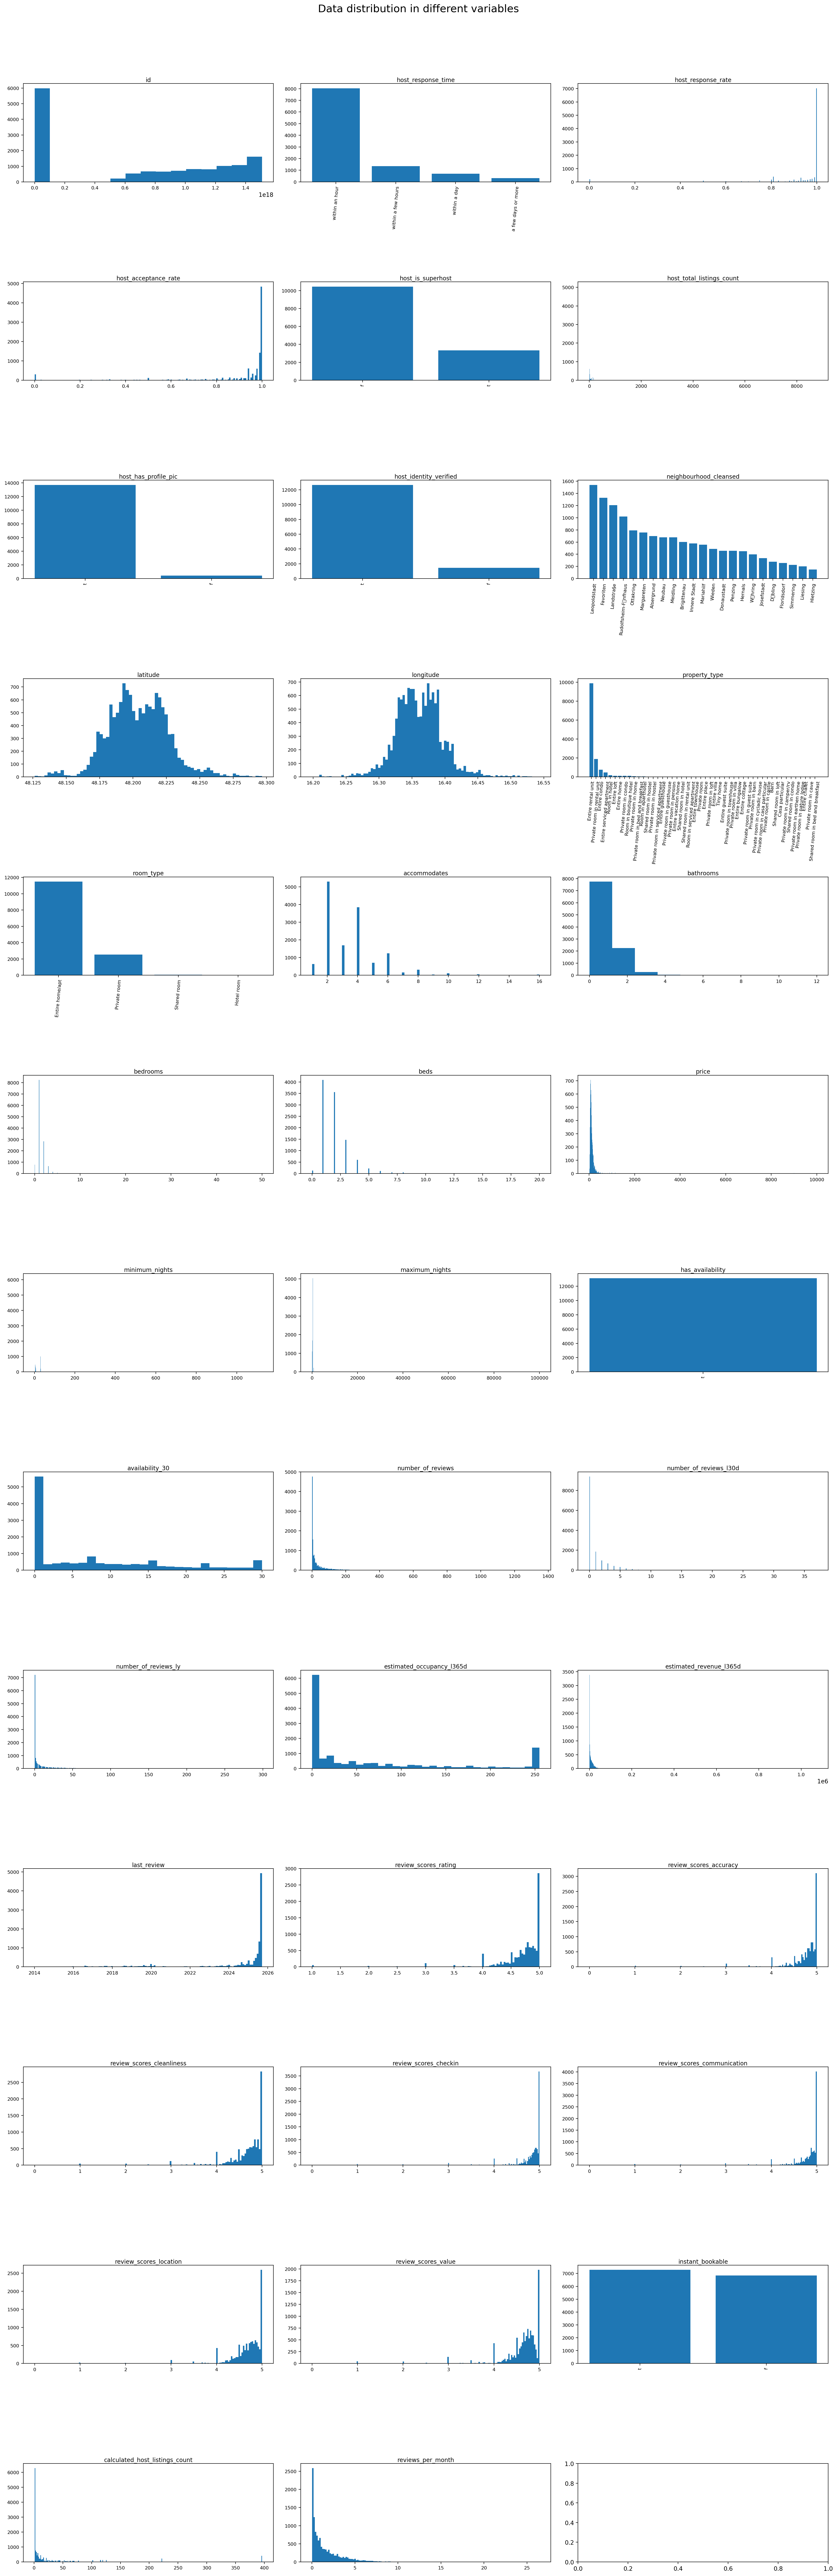

In [298]:
distr_plt_code_writer = student_a

def plot_distributions():
    fig, ax = plt.subplots(13, 3, figsize=(20, 60), dpi=200)
    plt.subplots_adjust(hspace=0.3,wspace=0.4)

    vars = data_dict_reduced['variable'].values
    idx = 0

    for row in range(13):
        for col in range(3):
            if idx < len(vars):
                var = vars[idx]

                if pd.api.types.infer_dtype(data[var]) == 'string':
                    counts = data[var].value_counts()
                    ax[row, col].bar(counts.index, counts.values)
                    ax[row, col].tick_params(axis='x', labelrotation=85, labelsize=8)
                elif var == 'bathrooms':
                    ax[row, col].hist(data[var])
                    ax[row, col].tick_params(axis='x', labelsize=8)
                else:
                    ax[row, col].hist(data[var], bins='fd')
                    ax[row, col].tick_params(axis='x', labelsize=8)

                ax[row, col].tick_params(axis='y', labelsize=8)
                ax[row, col].set_title(var, fontsize=10, pad=3)

                idx += 1


    fig.suptitle('Data distribution in different variables', fontsize=18, y=1.02)
    fig.tight_layout()
    plt.show()

# ============================================================
# 1) Plot distributions
# ============================================================

start_time_ld = now()
plot_distributions()
end_time_ld = now()


# ============================================================
# 2) Documentation
# ============================================================

dp_ass_uuid_executor = "1aa723fd-c346-4b82-9385-26c49767412a"
dp_ass_uuid_writer   = "c3c1fa3b-02aa-4e78-9e71-df59bdbfe8b7"

dp_comment = """
Visual exploration: plot raw distributions for all selected variables (data_dict_reduced).
Categorical/string variables are visualized via bar plots (value_counts); numerical variables via histograms.
This raw view is used to identify skewed distributions, heavy tails, discrete mass points and potential outliers.
"""
dp_comment_escaped = _escape_literal(dp_comment)

# executor association
dp_executor = [
    f':plot_distributions prov:qualifiedAssociation :{dp_ass_uuid_executor} .',
    f':{dp_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dp_ass_uuid_executor} rdf:type prov:Association .',
    f':{dp_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(dp_executor, prefixes=prefixes)

# activity + output entity (figure)
dp_activity = [
    ':plot_distributions rdf:type prov:Activity .',
    ':plot_distributions sc:isPartOf :data_understanding_phase .',
    ':plot_distributions rdfs:comment "Data Understanding – Visual exploration (raw distributions)" .',
    f':plot_distributions rdfs:comment "{dp_comment_escaped}" .',
    f':plot_distributions prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':plot_distributions prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',

    f':plot_distributions prov:qualifiedAssociation :{dp_ass_uuid_writer} .',
    f':{dp_ass_uuid_writer} prov:agent :{distr_plt_code_writer} .',
    f':{dp_ass_uuid_writer} rdf:type prov:Association .',
    f':{dp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # inputs
    ':plot_distributions prov:used :data .',
    ':plot_distributions prov:used :data_dict_reduced .',

    # output: figure entity
    ':distributions_figure_raw rdf:type prov:Entity .',
    ':distributions_figure_raw rdf:type sc:CreativeWork .',
    ':distributions_figure_raw sc:name "Distributions of selected variables (raw)" .',
    ':distributions_figure_raw sc:description "Grid of bar plots (categorical) and histograms (numeric) showing raw distributions for the selected variables." .',
    ':distributions_figure_raw prov:wasGeneratedBy :plot_distributions .',
]
engine.insert(dp_activity, prefixes=prefixes)

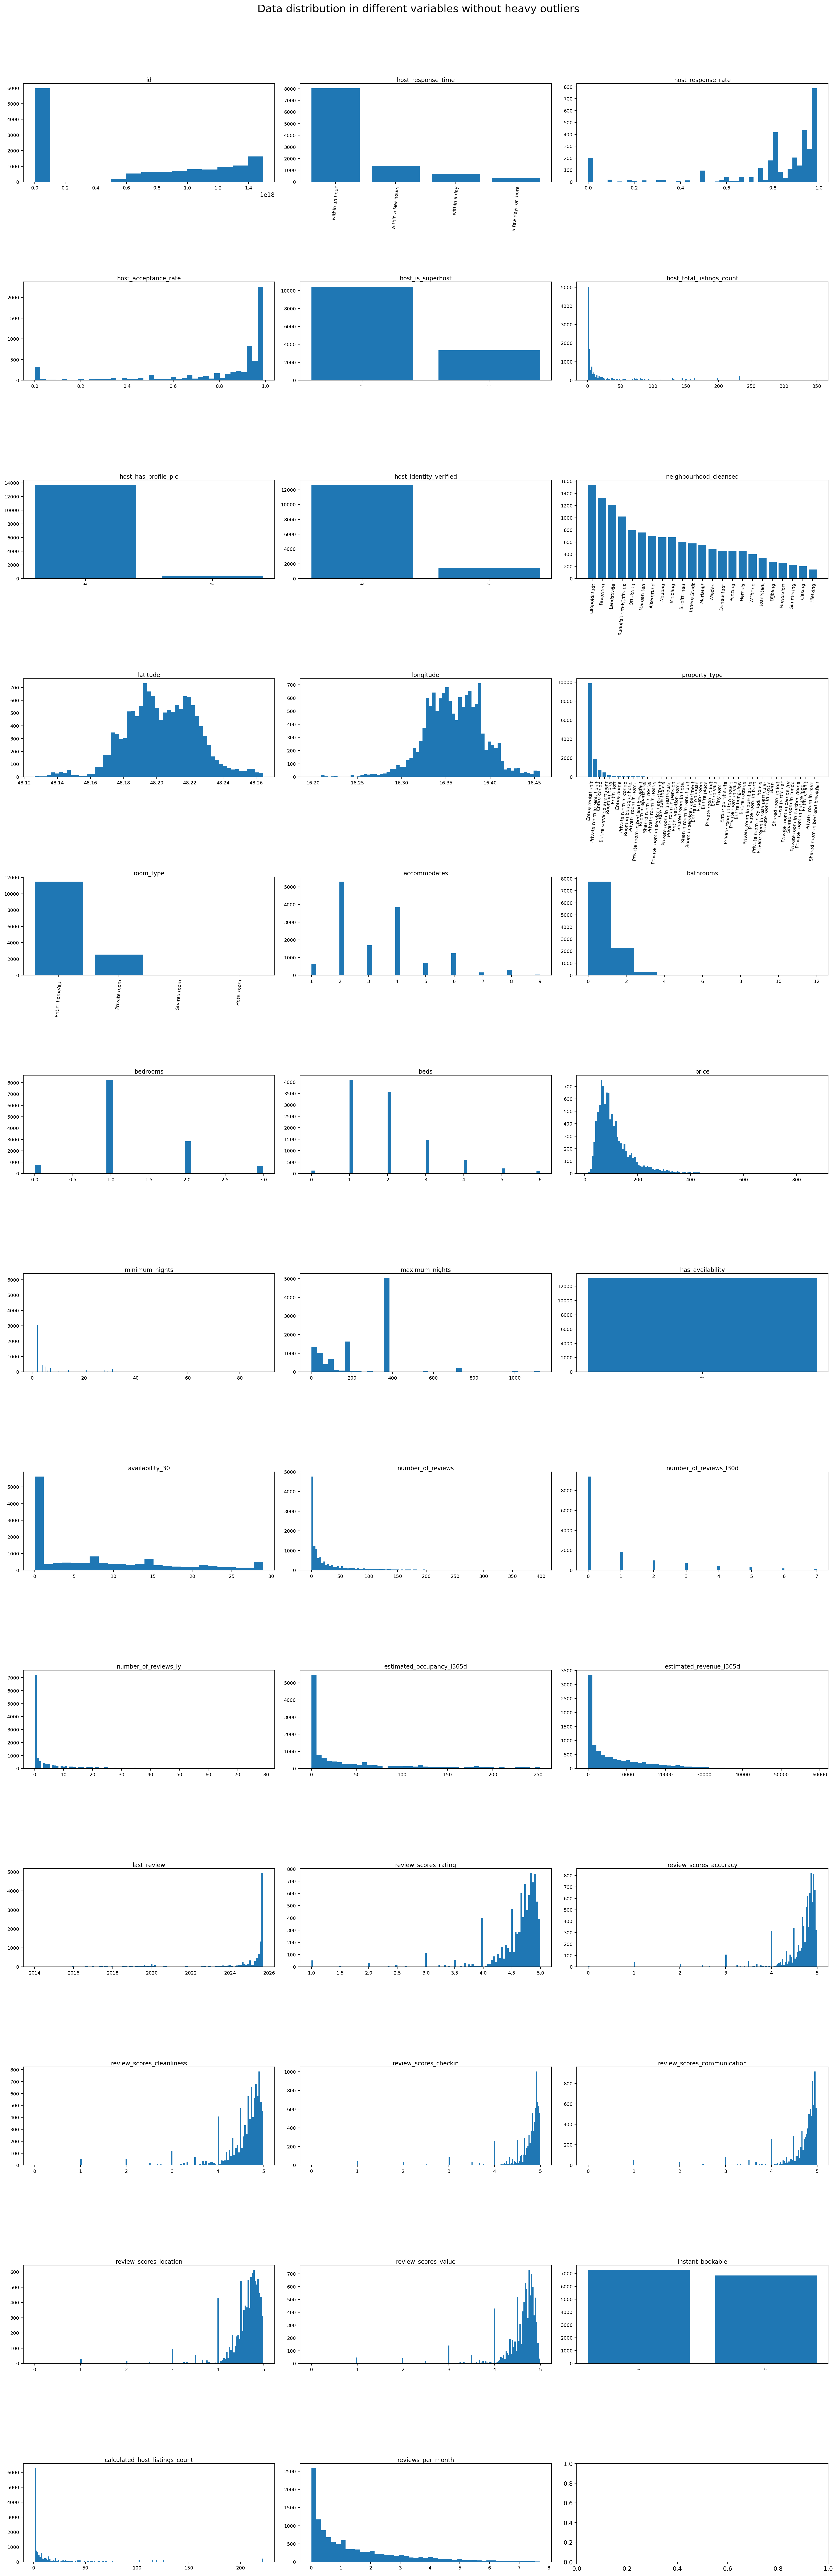

In [299]:
distr_plt_outlier_robust_code_writer = student_a

def plot_distributions_outlier_robust():
    fig, ax = plt.subplots(13, 3, figsize=(20, 60), dpi=200)
    plt.subplots_adjust(hspace=0.3,wspace=0.4)

    vars = data_dict_reduced['variable'].values
    idx = 0

    for row in range(13):
        for col in range(3):
            if idx < len(vars):
                var = vars[idx]

                if pd.api.types.infer_dtype(data[var]) == 'string':
                    counts = data[var].value_counts()
                    ax[row, col].bar(counts.index, counts.values)
                    ax[row, col].tick_params(axis='x', labelrotation=85, labelsize=8)

                else:
                    try:
                        skew = data[var].skew() < 0
                        if skew < 0:
                            ax[row, col].hist(data[(data[var] > data[var].quantile(0.01))][var], bins='fd')
                        elif var == 'bathrooms':
                            ax[row, col].hist(data[var])
                            ax[row, col].tick_params(axis='x', labelsize=8)
                        else:
                            ax[row, col].hist(data[(data[var] < data[var].quantile(0.99))][var], bins='fd')
                    except:
                        ax[row, col].hist(data[var], bins='fd')

                    ax[row, col].tick_params(axis='x', labelsize=8)

                ax[row, col].tick_params(axis='y', labelsize=8)
                ax[row, col].set_title(var, fontsize=10, pad=3)

                idx += 1


    fig.suptitle('Data distribution in different variables without heavy outliers', fontsize=18, y=1.02)
    fig.tight_layout()
    plt.show()

# ============================================================
# 1) Plot distributions
# ============================================================

start_time_ld = now()
plot_distributions_outlier_robust()
end_time_ld = now()

# ============================================================
# 2) Documentation
# ============================================================

dpr_ass_uuid_executor = "1c53d37c-01bc-4dcb-8ff5-6b3f1da0a8f4"
dpr_ass_uuid_writer   = "66dcf268-ae8a-4a15-8dba-010404e6fd67"

dpr_comment = """
Visual exploration: plot distributions with reduced influence of heavy outliers.
For numeric variables, the plotted range is restricted using quantile-based trimming (typically 1% or 99%),
to improve readability and reveal structure in the central mass of the distribution.
This view complements the raw distribution plots and supports plausibility assessment of outlier detection.
"""
dpr_comment_escaped = _escape_literal(dpr_comment)

# executor association
dpr_executor = [
    f':plot_distributions_outlier_robust prov:qualifiedAssociation :{dpr_ass_uuid_executor} .',
    f':{dpr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dpr_ass_uuid_executor} rdf:type prov:Association .',
    f':{dpr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(dpr_executor, prefixes=prefixes)

# activity + output entity (figure)
dpr_activity = [
    ':plot_distributions_outlier_robust rdf:type prov:Activity .',
    ':plot_distributions_outlier_robust sc:isPartOf :data_understanding_phase .',
    ':plot_distributions_outlier_robust rdfs:comment "Data Understanding – Visual exploration (outlier-robust distributions)" .',
    f':plot_distributions_outlier_robust rdfs:comment "{dpr_comment_escaped}" .',
    f':plot_distributions_outlier_robust prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':plot_distributions_outlier_robust prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',

    f':plot_distributions_outlier_robust prov:qualifiedAssociation :{dpr_ass_uuid_writer} .',
    f':{dpr_ass_uuid_writer} prov:agent :{distr_plt_outlier_robust_code_writer} .',
    f':{dpr_ass_uuid_writer} rdf:type prov:Association .',
    f':{dpr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # inputs
    ':plot_distributions_outlier_robust prov:used :data .',
    ':plot_distributions_outlier_robust prov:used :data_dict_reduced .',
    ':plot_distributions_outlier_robust prov:wasInformedBy :plot_distributions .',

    # output: figure entity
    ':distributions_figure_trimmed rdf:type prov:Entity .',
    ':distributions_figure_trimmed rdf:type sc:CreativeWork .',
    ':distributions_figure_trimmed sc:name "Distributions of selected variables (trimmed / outlier-robust)" .',
    ':distributions_figure_trimmed sc:description "Grid of plots showing distributions after quantile-based trimming to reduce the influence of heavy outliers." .',
    ':distributions_figure_trimmed prov:wasGeneratedBy :plot_distributions_outlier_robust .',
]
engine.insert(dpr_activity, prefixes=prefixes)

In [300]:
# ============================================================
# Bias and Risk Reflection
# ============================================================

start_time_bias = now()
end_time_bias = now()

bias_ass_uuid_executor = "1afe1eb8-9e7a-4866-b8a5-6f63b45161e9"

bias_reflection = """
Bias and risk reflection:

- Variable selection bias: Only a subset of 38 out of 79 available variables was selected based on business relevance and feasibility, excluding free-text fields and short-term aggregates (where different aggreagation intervals were available for a variable), which may omit relevant information contained in the deleted variables.
- Rating bias: Rating scores are subjective and scales are typically interpreted differntly by different users. Often users tend to avoid low ratings, resulting in left-skewed distributions and reduced variance (as we can see in the summary statistics).
- Popularity proxy bias: We want to use monthly review frequency as a proxy for popularity, but it reflects recent review activity rather than true or long-term demand, potentially underestimating popular listings with long review histories (where users might feel less of a need to still post their review).
- Platform and sampling bias: The dataset only represents Airbnb listings and does not capture the full short-term rental or housing market, which limits generalizability beyond the platform.
- Temporal snapshot bias: The dataset represents a single scrape / time point (14th September 2025); changes over time (trends, seasonality, and platform or market dynamics) are not observed.
"""
bias_reflection_escaped = _escape_literal(bias_reflection)

bias_reflection_activity = [
    ':reflect_biases_data_understanding rdf:type prov:Activity .',
    ':reflect_biases_data_understanding sc:isPartOf :data_understanding_phase .',
    ':reflect_biases_data_understanding rdfs:comment "Data Understanding – Bias and risk reflection" .',
    f':reflect_biases_data_understanding rdfs:comment "{bias_reflection_escaped}" .',
    f':reflect_biases_data_understanding prov:startedAtTime "{start_time_bias}"^^xsd:dateTime .',
    f':reflect_biases_data_understanding prov:endedAtTime "{end_time_bias}"^^xsd:dateTime .',

    f':reflect_biases_data_understanding prov:qualifiedAssociation :{bias_ass_uuid_executor} .',
    f':{bias_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{bias_ass_uuid_executor} rdf:type prov:Association .',
    f':{bias_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    f':data_understanding_phase rdfs:comment "{bias_reflection_escaped}" .',

    ':data_understanding_bias_reflection rdf:type prov:Entity .',
    ':data_understanding_bias_reflection prov:wasGeneratedBy :reflect_biases_data_understanding .',
    f':data_understanding_bias_reflection rdfs:comment "{bias_reflection_escaped}" .',
]
engine.insert(bias_reflection_activity, prefixes=prefixes)

In [301]:
data.head(20)

,id,review_scores_rating,review_scores_cleanliness,review_scores_location,review_scores_communication,review_scores_value,review_scores_accuracy,review_scores_checkin,host_is_superhost,reviews_per_month,...,host_total_listings_count,estimated_occupancy_l365d,estimated_revenue_l365d,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,maximum_nights,last_review
0,40625,4.86,4.89,4.61,4.94,4.73,4.91,4.89,NaN,1.22,...,18.0,48.0,6720.0,within an hour,1.0,0.95,t,t,365.0,2025-08-20
1,51287,4.67,4.51,4.87,4.95,4.59,4.78,4.92,t,2.15,...,3.0,180.0,12780.0,within an hour,1.0,1.00,t,t,180.0,2025-07-04
2,109679,4.87,4.91,4.66,4.92,4.82,4.87,4.91,NaN,0.93,...,18.0,54.0,3564.0,within an hour,1.0,0.95,t,t,365.0,2025-08-09
3,114505,4.88,4.89,4.71,4.96,4.80,4.90,4.96,NaN,0.71,...,18.0,0.0,0.0,within an hour,1.0,0.95,t,t,365.0,2022-12-30
4,131628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,...,2.0,0.0,NaN,NaN,NaN,NaN,t,t,180.0,NaT
5,138264,5.00,5.00,5.00,5.00,4.17,5.00,5.00,t,0.07,...,18.0,0.0,0.0,NaN,NaN,1.00,t,t,730.0,2023-05-07
6,169672,4.77,4.71,4.91,4.76,4.77,4.80,4.81,t,2.59,...,1.0,120.0,6960.0,within an hour,1.0,0.69,t,t,30.0,2025-09-10
7,169752,4.85,4.82,4.96,4.94,4.75,4.88,4.96,t,0.89,...,11.0,54.0,3132.0,within an hour,1.0,0.99,t,t,180.0,2025-08-26
8,169852,4.72,4.77,4.78,4.95,4.77,4.84,4.96,t,0.55,...,11.0,6.0,NaN,within an hour,1.0,0.99,t,t,180.0,2024-09-15
9,171835,4.68,4.78,4.95,4.90,4.73,4.76,4.91,t,1.15,...,1.0,72.0,5832.0,within an hour,1.0,0.67,t,t,10.0,2025-08-18


In [ ]:
data = data_raw.copy()

variable_subselection = [
    "id",
    "review_scores_rating",
    "review_scores_cleanliness",
    "review_scores_location",
    "review_scores_communication",
    "review_scores_value",
    "review_scores_accuracy",
    "review_scores_checkin",
    "host_is_superhost",
    "reviews_per_month",
    "number_of_reviews_l30d",
    "number_of_reviews_ly",
    "number_of_reviews",
    "accommodates",
    "room_type",
    "property_type",
    "minimum_nights",
    "instant_bookable",
    "has_availability",
    "availability_30",
    "price",
    "latitude",
    "longitude",
    "bathrooms",
    "beds",
    "bedrooms",
    "neighbourhood_cleansed",
    "calculated_host_listings_count",
    "host_total_listings_count",
    "estimated_occupancy_l365d",
    "estimated_revenue_l365d",
    "host_response_time",
    "host_response_rate",
    "host_acceptance_rate",
    "host_has_profile_pic",
    "host_identity_verified",
    "maximum_nights",
    "last_review"
]

data = data[variable_subselection].copy()


# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------

def bool_to_numeric(col):
    return (
        col.astype(str).str.lower().map({
            "t": 1,
            "f": 0,
        })
    ).astype("float64")

def percent_to_float(col):
    """
    Convert percentage strings (e.g., '100%') into normalized floats (1.0).
    Missing or malformed values remain NaN.
    """
    return (
        col.astype(str)
           .str.replace("%", "", regex=False)
           .replace({"nan": np.nan, "": np.nan})
           .astype(float) / 100.0
    )

def clean_price(x):
    """
    Remove currency symbols and commas from price strings.
    Convert to numeric and coerce non-parsable entries to NaN.
    """
    if isinstance(x, str):
        x = x.replace("$", "").replace(",", "")
    return pd.to_numeric(x, errors="coerce")


# ------------------------------------------------------------
# Boolean fields: Convert 'true'/'false' -> 1/0
# ------------------------------------------------------------
data["host_is_superhost"] = bool_to_numeric(data["host_is_superhost"])
data["instant_bookable"] = bool_to_numeric(data["instant_bookable"])
data["has_availability"] = bool_to_numeric(data["has_availability"])
data["host_has_profile_pic"] = bool_to_numeric(data["host_has_profile_pic"])
data["host_identity_verified"] = bool_to_numeric(data["host_identity_verified"])


# ------------------------------------------------------------
# Convert to numeric, fill missing with 0
# ------------------------------------------------------------
data["reviews_per_month"] = pd.to_numeric(data["reviews_per_month"], errors="coerce").fillna(0)


# # ------------------------------------------------------------
# # Price: Clean, convert, drop missing, remove implausible outliers
# # Based on earlier findings: large number of missing price entries,
# # and unrealistic values > 99.9th percentile.
# # ------------------------------------------------------------
# data["price"] = data["price"].apply(clean_price)

# # Remove listings with missing or non-positive prices
# data = data[data["price"].notna() & (data["price"] > 0)]

# # Remove extremely high nightly prices above the 99.9th percentile
# p999 = data["price"].quantile(0.999)
# data = data[data["price"] <= p999]


# ------------------------------------------------------------
# Beds / Bedrooms: Convert to numeric and treat 0 as invalid (set to NaN)
# ------------------------------------------------------------
for col in ["beds", "bedrooms"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")
    data[col] = data[col].replace(0, np.nan) 


# # ------------------------------------------------------------
# # Mark certain variables as categorical (for one-hot encoding later)
# # ------------------------------------------------------------
# data["neighbourhood_cleansed"] = data["neighbourhood_cleansed"].astype("category")
# data["room_type"] = data["room_type"].astype("category")
# data["property_type"] = data["property_type"].astype("category")
# data["host_response_time"] = data["host_response_time"].astype("category")

# # ------------------------------------------------------------
# # One-Hot Encode categorical variables
# # Expand categorical variables into dummy indicators.
# # ------------------------------------------------------------
# categorical_cols = [
#     "room_type",
#     "property_type",
#     "neighbourhood_cleansed",
#     "host_response_time"
# ]

# data_encoded = pd.get_dummies(
#     data,
#     columns=categorical_cols,
#     prefix=categorical_cols,
#     drop_first=False 
# )


# ------------------------------------------------------------
# Convert host percentage fields to float
# ------------------------------------------------------------
data["host_response_rate"] = percent_to_float(data["host_response_rate"])
data["host_acceptance_rate"] = percent_to_float(data["host_acceptance_rate"])


# ------------------------------------------------------------
# Date conversion: Convert last_review to datetime
# ------------------------------------------------------------
data["last_review"] = pd.to_datetime(data["last_review"], errors="coerce")


# ------------------------------------------------------------
# # Maximum nights: Remove implausible placeholder 99999
# # ------------------------------------------------------------
# data["maximum_nights"] = pd.to_numeric(data["maximum_nights"], errors="coerce")
# data = data[data["maximum_nights"] != 99999]

In [306]:
pd.set_option("display.max_columns", None)
data.head(20)

,id,review_scores_rating,review_scores_cleanliness,review_scores_location,review_scores_communication,review_scores_value,review_scores_accuracy,review_scores_checkin,host_is_superhost,reviews_per_month,number_of_reviews_l30d,number_of_reviews_ly,number_of_reviews,accommodates,room_type,property_type,minimum_nights,instant_bookable,has_availability,availability_30,price,latitude,longitude,bathrooms,beds,bedrooms,neighbourhood_cleansed,calculated_host_listings_count,host_total_listings_count,estimated_occupancy_l365d,estimated_revenue_l365d,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,maximum_nights,last_review
0,40625,4.86,4.89,4.61,4.94,4.73,4.91,4.89,NaN,1.22,1,15,225,6,Entire home/apt,Entire rental unit,1,0.0,1.0,18,140.0,48.184340,16.327010,1.0,3.0,2.0,Rudolfsheim-Fnfhaus,14,18.0,48,6720.0,within an hour,1.0,0.95,1.0,1.0,365,2025-08-20
1,51287,4.67,4.51,4.87,4.95,4.59,4.78,4.92,1.0,2.15,0,9,383,2,Entire home/apt,Entire rental unit,30,0.0,1.0,0,71.0,48.217780,16.378470,1.0,2.0,NaN,Leopoldstadt,2,3.0,180,12780.0,within an hour,1.0,1.00,1.0,1.0,180,2025-07-04
2,109679,4.87,4.91,4.66,4.92,4.82,4.87,4.91,NaN,0.93,0,8,152,4,Entire home/apt,Entire rental unit,1,0.0,1.0,0,66.0,48.184670,16.327950,1.0,4.0,NaN,Rudolfsheim-Fnfhaus,14,18.0,54,3564.0,within an hour,1.0,0.95,1.0,1.0,365,2025-08-09
3,114505,4.88,4.89,4.71,4.96,4.80,4.90,4.96,NaN,0.71,0,0,124,4,Entire home/apt,Entire rental unit,1,0.0,1.0,29,96.0,48.184450,16.327220,1.0,3.0,NaN,Rudolfsheim-Fnfhaus,14,18.0,0,0.0,within an hour,1.0,0.95,1.0,1.0,365,2022-12-30
5,138264,5.00,5.00,5.00,5.00,4.17,5.00,5.00,1.0,0.07,0,0,6,4,Entire home/apt,Entire condo,1,1.0,1.0,8,151.0,48.223530,16.317730,1.0,2.0,1.0,Hernals,14,18.0,0,0.0,NaN,NaN,1.00,1.0,1.0,730,2023-05-07
6,169672,4.77,4.71,4.91,4.76,4.77,4.80,4.81,1.0,2.59,3,24,445,2,Private room,Private room in rental unit,2,0.0,1.0,2,58.0,48.195270,16.363740,1.0,1.0,1.0,Wieden,1,1.0,120,6960.0,within an hour,1.0,0.69,1.0,1.0,30,2025-09-10
7,169752,4.85,4.82,4.96,4.94,4.75,4.88,4.96,1.0,0.89,2,16,112,3,Entire home/apt,Entire rental unit,1,1.0,1.0,0,58.0,48.194690,16.359630,1.0,1.0,NaN,Margareten,11,11.0,54,3132.0,within an hour,1.0,0.99,1.0,1.0,180,2025-08-26
9,171835,4.68,4.78,4.95,4.90,4.73,4.76,4.91,1.0,1.15,1,11,195,3,Entire home/apt,Entire rental unit,3,0.0,1.0,0,81.0,48.195710,16.375010,1.0,2.0,2.0,Wieden,1,1.0,72,5832.0,within an hour,1.0,0.67,1.0,1.0,10,2025-08-18
10,172530,4.78,4.80,4.80,4.93,4.63,4.80,4.95,1.0,1.42,0,12,243,7,Entire home/apt,Entire rental unit,1,1.0,1.0,0,138.0,48.194690,16.359630,1.5,4.0,3.0,Margareten,11,11.0,30,4140.0,within an hour,1.0,0.99,1.0,1.0,180,2025-07-07
11,173375,4.83,4.82,4.79,4.84,4.81,4.89,4.89,1.0,1.68,4,43,289,4,Entire home/apt,Entire rental unit,2,0.0,1.0,1,82.0,48.216640,16.378420,1.0,2.0,1.0,Leopoldstadt,1,4.0,228,18696.0,within an hour,1.0,1.00,1.0,1.0,14,2025-09-07


In [ ]:

# No removal of high maximum_nights values except 99999

# Reason:
# The Data Understanding phase showed that the high value 1125 (≈3 years) appears 3317 times and is valid for long-term rentals.
# Only the outlier 99999 was a placeholder, appearing once.
# Therefore, we deleted only this single implausible value instead of applying global outlier trimming.
# --
# No removal of extreme but plausible values (beds, bedrooms, host_listing_count)

# Reason:
# Large values in these variables often correspond to hotels or professional property managers.
# These are semantically valid and should remain in the dataset.
# --
# No geospatial transformations of latitude/longitude

# Examples considered:
	# •	computing distances to city center
	# •	clustering neighborhoods
	# •	deriving regional zones

# Reason:
# These are feature engineering steps, not data cleaning.

# --
# No removal of columns with moderate missingness

# (Examples: host_response_time, host_response_rate, host_acceptance_rate, bathrooms, bedrooms)
# Removing these attributes would discard meaningful behavioral or business information.

# --
# No date-derived feature engineering from last_review

# We did not create features such as:
	# •	days since last review
	# •	recency buckets
	# •	seasonal review activity

# Reason:
# The Data Preparation step only converts to datetime to normalize format.

## Data Preparation

In [304]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [ ]:
handle_outliers_code_writer = student_b

def handle_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the outlier decisions derived in the Data Understanding phase.
    - Clean and trim price outliers.
    - Remove the implausible maximum_nights placeholder 99999.
    """
    data = df.copy()

    # ------------------------------------------------------------
    # Price: Clean, convert, drop missing, remove implausible outliers
    # ------------------------------------------------------------
    def clean_price(x):
        if isinstance(x, str):
            x = x.replace("$", "").replace(",", "")
        return pd.to_numeric(x, errors="coerce")

    data["price"] = data["price"].apply(clean_price)

    # Remove listings with missing or non-positive prices
    data = data[data["price"].notna() & (data["price"] > 0)]

    # Remove extremely high nightly prices above the 99.9th percentile
    p999 = data["price"].quantile(0.999)
    data = data[data["price"] <= p999]

    # ------------------------------------------------------------
    # Maximum nights: Remove implausible placeholder 99999
    # ------------------------------------------------------------
    data["maximum_nights"] = pd.to_numeric(data["maximum_nights"], errors="coerce")
    data = data[data["maximum_nights"] != 99999]

    return data

start_time_td = now()
handle_outliers(data)
end_time_td = now()

#############################################
# Documentation
#############################################

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [309]:
handle_categorical_data_code_writer = student_b

def handle_categorical_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Make certain variables categorical
    """
    data = df.copy()

    # ------------------------------------------------------------
    # Mark certain variables as categorical (for one-hot encoding later)
    # ------------------------------------------------------------
    data["neighbourhood_cleansed"] = data["neighbourhood_cleansed"].astype("category")
    data["room_type"] = data["room_type"].astype("category")
    data["property_type"] = data["property_type"].astype("category")
    data["host_response_time"] = data["host_response_time"].astype("category")

    # ------------------------------------------------------------
    # One-Hot Encode categorical variables
    # Expand categorical variables into dummy indicators.
    # ------------------------------------------------------------
    categorical_cols = [
        "room_type",
        "property_type",
        "neighbourhood_cleansed",
        "host_response_time"
    ]

    data_encoded = pd.get_dummies(
        data,
        columns=categorical_cols,
        prefix=categorical_cols,
        drop_first=False 
    )

    return data

start_time_td = now()
handle_categorical_data(data)
end_time_td = now()

#############################################
# Documentation
#############################################

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_categorical_data_executor = [
    f':handle_categorical_data prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_categorical_data_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Making certain data categorical.
"""
handle_categorical_data_activity = [
    ':handle_categorical_data rdf:type prov:Activity .',
    ':handle_categorical_data sc:isPartOf :data_preparation_phase .',
    ':handle_categorical_data rdfs:comment \'Data Preparation\' .', 
    f':handle_categorical_data rdfs:comment """{td_comment}""" .', 
    f':handle_categorical_data prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_categorical_data prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_categorical_data prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_categorical_data_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_categorical_data prov:used :data .',
    ':handle_categorical_data prov:used :categorical_data_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_categorical_data .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_categorical_data_activity, prefixes=prefixes)

In [310]:
handle_data_conversion_code_writer = student_b

def handle_data_conversion(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert data to the needed format.
    """
    data = df.copy()

    # ------------------------------------------------------------
    # Helper functions
    # ------------------------------------------------------------

    def bool_to_numeric(col):
        return (
            col.astype(str).str.lower().map({
                "t": 1,
                "f": 0,
            })
        ).astype("float64")

    def percent_to_float(col):
        """
        Convert percentage strings (e.g., '100%') into normalized floats (1.0).
        Missing or malformed values remain NaN.
        """
        return (
            col.astype(str)
            .str.replace("%", "", regex=False)
            .replace({"nan": np.nan, "": np.nan})
            .astype(float) / 100.0
        )

    # ------------------------------------------------------------
    # Boolean fields: Convert 'true'/'false' -> 1/0
    # ------------------------------------------------------------
    data["host_is_superhost"] = bool_to_numeric(data["host_is_superhost"])
    data["instant_bookable"] = bool_to_numeric(data["instant_bookable"])
    data["has_availability"] = bool_to_numeric(data["has_availability"])
    data["host_has_profile_pic"] = bool_to_numeric(data["host_has_profile_pic"])
    data["host_identity_verified"] = bool_to_numeric(data["host_identity_verified"])   

    # ------------------------------------------------------------
    # Convert to numeric, fill missing with 0
    # ------------------------------------------------------------
    data["reviews_per_month"] = pd.to_numeric(data["reviews_per_month"], errors="coerce").fillna(0) 

    # ------------------------------------------------------------
    # Convert host percentage fields to float
    # ------------------------------------------------------------
    data["host_response_rate"] = percent_to_float(data["host_response_rate"])
    data["host_acceptance_rate"] = percent_to_float(data["host_acceptance_rate"])

    # ------------------------------------------------------------
    # Beds / Bedrooms: Convert to numeric and treat 0 as invalid (set to NaN)
    # ------------------------------------------------------------
    for col in ["beds", "bedrooms"]:
        data[col] = pd.to_numeric(data[col], errors="coerce")
        data[col] = data[col].replace(0, np.nan) 

    # ------------------------------------------------------------
    # Date conversion: Convert last_review to datetime
    # ------------------------------------------------------------
    data["last_review"] = pd.to_datetime(data["last_review"], errors="coerce")

    return data

start_time_td = now()
handle_data_conversion(data)
end_time_td = now()

#############################################
# Documentation
#############################################

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_data_conversion_executor = [
    f':handle_data_conversion prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_data_conversion_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Converting the data for easier usage.
"""
handle_data_conversion_activity = [
    ':handle_data_conversion rdf:type prov:Activity .',
    ':handle_data_conversion sc:isPartOf :data_preparation_phase .',
    ':handle_data_conversion rdfs:comment \'Data Preparation\' .', 
    f':handle_data_conversion rdfs:comment """{td_comment}""" .', 
    f':handle_data_conversion prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_data_conversion prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_data_conversion prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_data_conversion_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_data_conversion prov:used :data .',
    ':handle_data_conversion prov:used :data_conversion_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_data_conversion .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_data_conversion_activity, prefixes=prefixes)

In [ ]:
prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data rdf:type sc:Dataset .',

    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data sc:isBasedOn :airbnb_data_subset .',

    ':prepared_data sc:name "Prepared Airbnb modelling dataset (Vienna)" .',
    ':prepared_data sc:description "Transformed dataset after outlier handling, data conversion, and categorical encoding" .',

    ':prepared_recordset rdf:type cr:RecordSet .',
    ':prepared_recordset sc:name "Prepared Airbnb feature table" .',
    ':prepared_data cr:recordSet :prepared_recordset .',
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [ ]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [ ]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [ ]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [ ]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [ ]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [ ]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [ ]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [ ]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [ ]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [ ]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data/report/experiment_report.tex
